In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import folium
import branca
from datetime import datetime, timedelta,date
import plotly.express as px
import json, requests

from keras.layers import Input, Dense, Activation, LeakyReLU
from keras import models
from keras.optimizers import RMSprop, Adam

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Using TensorFlow backend.


In [2]:
df_india_test = pd.io.json.json_normalize(requests.get('https://api.rootnet.in/covid19-in/stats/testing/history').json()['data']).rename(columns = {"totalIndividualsTested":"c_individualtest","totalPositiveCases":"c_positive","totalSamplesTested":"c_tests"})

In [3]:
df_india_test["p2t_ratio"]= np.round(100*df_india_test["c_positive"]/df_india_test["c_tests"],2)
df_india_test["positive"] = df_india_test["c_positive"].diff()
df_india_test["tests"] = df_india_test["c_tests"].diff()
df_india_test["p2t_ratio"]= np.round(100*df_india_test["positive"]/df_india_test["tests"],2)
df_india_test = df_india_test[1:]

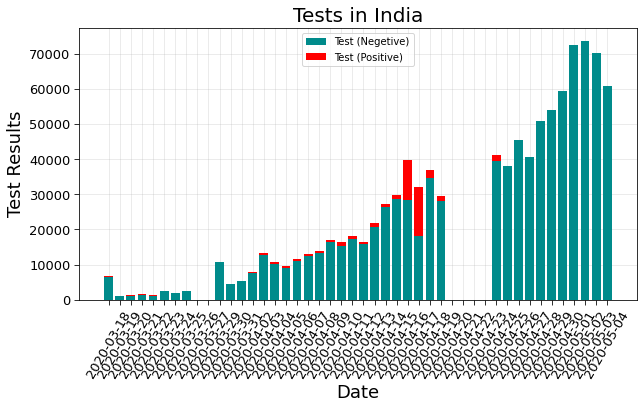

In [4]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.bar(df_india_test["day"],df_india_test["tests"].values[:],color="darkcyan",label="Test (Negetive)"+str())
plt.bar(df_india_test["day"],df_india_test["positive"].values[:],bottom=df_india_test["tests"].values[:]-df_india_test["positive"].values[:],color="Red",label="Test (Positive)")
plt.tick_params(size=5,labelsize = 13)
plt.tick_params(axis="x",size=5,labelsize = 13,labelrotation=60 )
plt.xlabel("Date",fontsize=18)
plt.ylabel("Test Results",fontsize=18)

plt.title("Tests in India",fontsize=20)
plt.grid(alpha=0.3)
plt.legend()
plt.savefig('Test_India.png')

### No. of tests in India till now

In [5]:
df_india_test["c_tests"][-1:].values[0]

1107233.0

### Test conducted per Million people

In [6]:
np.round(1000000*df_india_test["c_tests"][-1:].values[0]/1300000000,2)

851.72

### Covid-19 cases in India

In [7]:
india_data_json = requests.get('https://api.rootnet.in/covid19-in/unofficial/covid19india.org/statewise').json()
df_india = pd.io.json.json_normalize(india_data_json['data']['statewise'])
df_india = df_india.set_index("state")

In [8]:
total = df_india.sum()
total.name = "Total"
df_t = pd.DataFrame(total,dtype=float).transpose()
df_t["Mortality Rate (per 100)"] = np.round(100*df_t["deaths"]/df_t["confirmed"],2)
df_t.style.background_gradient(cmap='Purples',axis=1)

,active,confirmed,deaths,recovered,Mortality Rate (per 100)
Total,29505,42698,1396,11793,3.27


In [9]:
df_india["Mortality Rate (per 100)"]= np.round(np.nan_to_num(100*df_india["deaths"]/df_india["confirmed"]),2)
df_india.style.background_gradient(cmap='Blues',subset=["confirmed"])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='Greens',subset=["recovered"])\
                        .background_gradient(cmap='Purples',subset=["active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,active,confirmed,deaths,recovered,Mortality Rate (per 100)
state,,,,,
Maharashtra,10311,12974,548,2115,4.22
Gujarat,4096,5428,290,1042,5.34
Delhi,3123,4549,64,1362,1.41
Madhya Pradesh,1883,2837,156,798,5.5
Rajasthan,1578,3009,75,1356,2.49
Tamil Nadu,1614,3023,30,1379,0.99
Uttar Pradesh,1848,2645,43,754,1.63
Andhra Pradesh,1062,1583,33,488,2.08
Telangana,508,1082,29,545,2.68


In [10]:
df_india[df_india['deaths'] > 0].style.background_gradient(cmap='Blues',subset=["confirmed"])\
                        .background_gradient(cmap='Reds',subset=["deaths"])\
                        .background_gradient(cmap='Greens',subset=["recovered"])\
                        .background_gradient(cmap='Purples',subset=["active"])\
                        .background_gradient(cmap='YlOrBr',subset=["Mortality Rate (per 100)"])

,active,confirmed,deaths,recovered,Mortality Rate (per 100)
state,,,,,
Maharashtra,10311,12974,548,2115,4.22
Gujarat,4096,5428,290,1042,5.34
Delhi,3123,4549,64,1362,1.41
Madhya Pradesh,1883,2837,156,798,5.5
Rajasthan,1578,3009,75,1356,2.49
Tamil Nadu,1614,3023,30,1379,0.99
Uttar Pradesh,1848,2645,43,754,1.63
Andhra Pradesh,1062,1583,33,488,2.08
Telangana,508,1082,29,545,2.68


### 10 most affected states

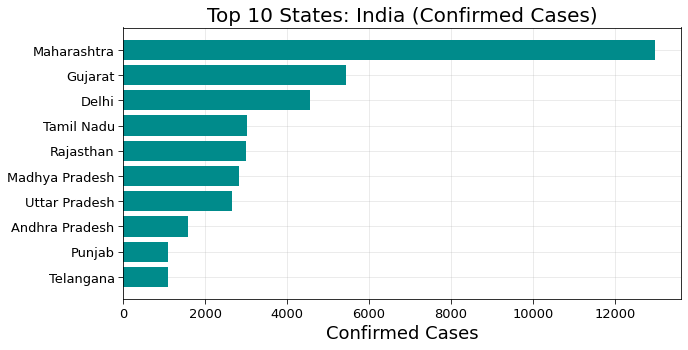

In [11]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('confirmed')["confirmed"].index[-10:],df_india.sort_values('confirmed')["confirmed"].values[-10:],color="darkcyan")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Confirmed Cases",fontsize=18)
plt.title("Top 10 States: India (Confirmed Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States_India (Confirmed Cases).png')

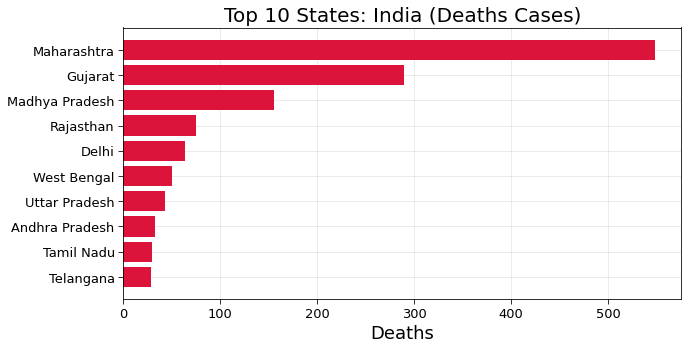

In [12]:
f = plt.figure(figsize=(10,5))
f.add_subplot(111)

plt.axes(axisbelow=True)
plt.barh(df_india.sort_values('deaths')["deaths"].index[-10:],df_india.sort_values('deaths')["deaths"].values[-10:],color="crimson")
plt.tick_params(size=5,labelsize = 13)
plt.xlabel("Deaths",fontsize=18)
plt.title("Top 10 States: India (Deaths Cases)",fontsize=20)
plt.grid(alpha=0.3)
plt.savefig('Top 10 States_India (Deaths Cases).png')

### Correlation

In [13]:
df_india.corr().style.background_gradient(cmap='Reds')

,active,confirmed,deaths,recovered,Mortality Rate (per 100)
active,1,0.994245,0.964141,0.854576,0.364576
confirmed,0.994245,1,0.950049,0.905035,0.371591
deaths,0.964141,0.950049,1,0.770043,0.437346
recovered,0.854576,0.905035,0.770043,1,0.336886
Mortality Rate (per 100),0.364576,0.371591,0.437346,0.336886,1


### Map visualization

In [14]:
# Adding Location data (Latitude,Longitude)
locations = {
    "Kerala" : [10.8505,76.2711],
    "Maharashtra" : [19.7515,75.7139],
    "Karnataka": [15.3173,75.7139],
    "Telangana": [18.1124,79.0193],
    "Uttar Pradesh": [26.8467,80.9462],
    "Rajasthan": [27.0238,74.2179],
    "Gujarat":[22.2587,71.1924],
    "Delhi" : [28.7041,77.1025],
    "Punjab":[31.1471,75.3412],
    "Tamil Nadu": [11.1271,78.6569],
    "Haryana": [29.0588,76.0856],
    "Madhya Pradesh":[22.9734,78.6569],
    "Jammu and Kashmir":[33.7782,76.5762],
    "Ladakh": [34.1526,77.5770],
    "Andhra Pradesh":[15.9129,79.7400],
    "West Bengal": [22.9868,87.8550],
    "Bihar": [25.0961,85.3131],
    "Chhattisgarh":[21.2787,81.8661],
    "Chandigarh":[30.7333,76.7794],
    "Uttarakhand":[30.0668,79.0193],
    "Himachal Pradesh":[31.1048,77.1734],
    "Goa": [15.2993,74.1240],
    "Odisha":[20.9517,85.0985],
    "Andaman and Nicobar Islands": [11.7401,92.6586],
    "Puducherry":[11.9416,79.8083],
    "Manipur":[24.6637,93.9063],
    "Mizoram":[23.1645,92.9376],
    "Assam":[26.2006,92.9376],
    "Meghalaya":[25.4670,91.3662],
    "Tripura":[23.9408,91.9882],
    "Arunachal Pradesh":[28.2180,94.7278],
    "Jharkhand" : [23.6102,85.2799],
    "Nagaland": [26.1584,94.5624],
    "Sikkim": [27.5330,88.5122],
    "Dadra and Nagar Haveli":[20.1809,73.0169],
    "Lakshadweep":[10.5667,72.6417],
    "Daman and Diu":[20.4283,72.8397]    
}
df_india["Lat"] = ""
df_india["Long"] = ""
for index in df_india.index :
    df_india.loc[df_india.index == index,"Lat"] = locations[index][0]
    df_india.loc[df_india.index == index,"Long"] = locations[index][1]

In [15]:
india = folium.Map(location=[23,80], zoom_start=4,max_zoom=6,min_zoom=4,height=500,width="80%")
for i in range(0,len(df_india[df_india['confirmed']>0].index)):
    folium.Circle(
        location=[df_india.iloc[i]['Lat'], df_india.iloc[i]['Long']],
        tooltip = "<h5 style='text-align:center;font-weight: bold'>"+df_india.iloc[i].name+"</h5>"+
                    "<hr style='margin:10px;'>"+
                    "<ul style='color: #444;list-style-type:circle;align-item:left;padding-left:20px;padding-right:20px'>"+
        "<li>Confirmed: "+str(df_india.iloc[i]['confirmed'])+"</li>"+
        "<li>Active:   "+str(df_india.iloc[i]['active'])+"</li>"+
        "<li>Recovered:   "+str(df_india.iloc[i]['recovered'])+"</li>"+
        "<li>Deaths:   "+str(df_india.iloc[i]['deaths'])+"</li>"+
        
        "<li>Mortality Rate:   "+str(np.round(df_india.iloc[i]['Mortality Rate (per 100)'],2))+"</li>"+
        "</ul>"
        ,
        radius=(int(np.log(df_india.iloc[i]['confirmed']+1)))*20000,
        color='#ff6600',
        fill_color='#ff8533',
        fill=True).add_to(india)

india